# Session setup

## libraries

In [1]:
# basic operations
import os
import logging
import re
from pprint import pprint as pp

# data analysis/management/manipulation
import numpy as np
import pandas as pd
import sklearn

# nlp pipeline
import spacy
import en_core_web_lg
MALLET_PATH = '/Users/omoi/Documents/SMM694-NLP/mallet-2.0.8/bin/mallet'

# text analysis
import gensim
from gensim import corpora
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

# multivariate analysis
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

# distance metrics
from scipy.spatial.distance import cosine

# visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyLDAvis
import pyLDAvis.gensim # directly import the module `gensim'!

## package version

In [2]:
print("""
spaCy version: {}
Gensim version: {}
""".format(spacy.__version__, gensim.__version__))


spaCy version: 2.1.3
Gensim version: 3.8.0



## working directory

In [3]:
PATH = os.getcwd()
FOLDER = 'brexit'

# Read data

In [4]:
FILE1 = 'pr__sus_attr.csv'
FILE2 = 'pr__sus_docs.csv'
FILE3 = 'pr__sources.csv'
pr_attr = pd.read_csv(os.path.join(PATH, FOLDER, FILE1))
pr_docs = pd.read_csv(os.path.join(PATH, FOLDER, FILE2))
pr_sources = pd.read_csv(os.path.join(PATH, FOLDER, FILE3))

In [5]:
pr_attr.columns

Index(['article', 'source', 'variable', 'value'], dtype='object')

In [6]:
pr_docs.columns

Index(['source', 'text', 'article', 'start', 'id', 'sort'], dtype='object')

## clean the data

In [7]:
pr_date = pr_attr[pr_attr.variable == 'date'].drop(['variable','source'], axis=1)

# the expected timespan is April 23, 2016 - August 23, 2016
pr_timespan = pr_date[(pr_date.value < '2016-08-24 00:00:00') & (pr_date.value >= '2016-04-23 00:00:00')]

# get list of chosen article id
articles = pr_timespan.article.to_list()

# join pr_docs and pr_timespan
pr = pd.merge(pr_timespan, pr_docs, on=['article', 'article']).rename(columns={'value':'date'})
pr.sort_values('date', inplace=True)

# NLP Pipeline

In [8]:
# prepare list to pass through spacy
docs = [article.strip().lower() for article in pr.text]

# hyphen to underscores
docs = [re.sub(r'\b-\b', '_', text) for text in docs]

## simple 'web_lg'

In [9]:
# load spaCy model 'web_lg'
nlp = en_core_web_lg.load()

In [10]:
# expand on spaCy's stopwords
# my stopwrods
my_stopwords = ['\x1c',
                'ft', 'wsj', 'time', 'sec',
                'say', 'says', 'said',
                'mr.', 'mister', 'mr', 'miss', 'ms',
                'inc']
# expand on spacy's stopwords
for stopword in my_stopwords:
    nlp.vocab[stopword].is_stop = True

In [11]:
# tokenize text
docs_tokens, tmp_tokens = [], []

for doc in docs:
    tmp_tokens = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop
                  and not token.is_space
                  and not token.is_punct
                  and not token.like_num
                  and not token.like_url
                  and not token.like_email
                  and not token.is_currency
                  and not token.is_oov]
    docs_tokens.append(tmp_tokens)
    tmp_tokens = []

In [12]:
phrases = Phrases(docs, min_count=30, progress_per=10000)

In [13]:
# get rid of common terms
common_terms = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']

# fing phrases as bigrams
bigram = Phrases(docs_tokens,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=common_terms)
# fing phrases as trigrams
trigram = Phrases(bigram[docs_tokens],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=common_terms)
# manipulate docs
DOCS_PHRASED = [trigram[line] for line in docs_tokens]

# check nlp pipeline
print('',
      'Published text:', docs[0],
      'Tokenized text:', docs_tokens[0],
      'Tri-grammed tokenised text:', DOCS_PHRASED[0])

 Published text: highlight: ed crooks is fascinated by a biography of the scientist who predicted that oil production would soon start falling  the oracle of oil: a maverick geologist\'s quest for a sustainable future by mason inman ww norton \xc5\x8120/ $29.95, 432 pages few scientific ideas have fallen out of favour as quickly as the claim that we are close to peak oil. the theory that the world\'s output of crude was nearing the highest level it would ever reach was never exactly orthodoxy, but less than a decade ago it had widespread support. the weak form of the hypothesis, suggesting that the world was past peak production of low_cost "easy oil", was a commonplace among investors and in oil company boardrooms. the plunge in crude prices since the summer of 2014, triggered by a boom in us production, has made a mockery of that assessment. today the world is awash with oil, and the conventional wisdom is that it will stay well supplied for a long time to come.  this might, then, se

limit_output extension: Maximum message size of 10000 exceeded with 12112 characters

# Topic Modelling

## Model building

### Text transformation

In [14]:
# create dictionary and text corpus
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

### Mallet's implementation of LDA algorithm (using Gibbs sampling)

In [15]:
'''
Based on Gardner et al's LQ paper, we expect to see
29 distinctive topics circa
'''
N_TOPICS = 5
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=5)

[(0,
  '0.053*"service" + 0.019*"community" + 0.011*"professor" + 0.010*"education" + 0.010*"health"'),
 (1,
  '0.017*"company" + 0.015*"business" + 0.014*"energy" + 0.008*"year" + 0.008*"work"'),
 (2,
  '0.010*"city" + 0.008*"it\\" + 0.007*"good" + 0.006*"include" + 0.005*"year"'),
 (3,
  '0.013*"government" + 0.009*"country" + 0.007*"people" + 0.006*"year" + 0.005*"eu"'),
 (4,
  '0.016*"uk" + 0.015*"market" + 0.011*"year" + 0.010*"cent" + 0.010*"week"')]

## Model evaluation

### Get range of coherence values as the number of retained topics change

In [16]:
# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = MALLET_PATH
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# collect coherence scores as the number of retained topics change
LIMIT, START, STEP = 10, 1, 1
MODEL_LIST, COHER_VALS = compute_coherence_values(dictionary=DICT,
                                                  corpus=CORPUS,
                                                  texts=DOCS_PHRASED,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

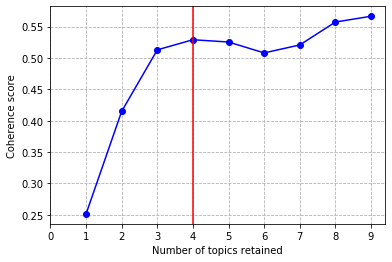

In [18]:
# plot collected coherence scores data

# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS

# create figure
FIG = plt.figure(figsize=(6, 4))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(0, 10, 1))

# reference line
AX.axvline(x=4, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')

# save plot to file
PATH = os.getcwd()
FOLDER = 'data'
FILE = 'B_0.pdf'
plt.savefig(os.path.join(PATH, FOLDER, FILE),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

plt.show()

In [19]:
# suggested number of topics to retain -- see above
N_TOPICS = 4

# model estimation
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)

# print results
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=10)

[(0,
  '0.045*"service" + 0.016*"community" + 0.011*"health" + 0.009*"professor" + 0.009*"education" + 0.009*"university" + 0.008*"director" + 0.007*"nhs" + 0.007*"school" + 0.007*"child"'),
 (1,
  '0.011*"company" + 0.010*"energy" + 0.010*"business" + 0.008*"work" + 0.007*"year" + 0.006*"government" + 0.006*"power" + 0.006*"people" + 0.005*"country" + 0.005*"cost"'),
 (2,
  '0.014*"uk" + 0.012*"market" + 0.012*"eu" + 0.010*"year" + 0.009*"cent" + 0.007*"week" + 0.006*"low" + 0.006*"growth" + 0.006*"brexit" + 0.006*"rise"'),
 (3,
  '0.008*"city" + 0.008*"it\\" + 0.008*"food" + 0.007*"good" + 0.007*"year" + 0.006*"include" + 0.005*"waste" + 0.005*"offer" + 0.004*"place" + 0.004*"people"')]

## Result visualization with pyLDAvis

### Copy the training model weights from Mallet to Gensim

In [20]:
# translate topic modeling outcome
LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)

In [21]:
# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.gensim.prepare(LDA_MALLET_G, CORPUS, DICT, sort_topics=False)
pyLDAvis.display(DATA_VIS)

limit_output extension: Maximum message size of 10000 exceeded with 45105 characters

In [22]:
# save pyLDAvis data to json file
pyLDAvis.save_json(DATA_VIS, 'topic_modelling_vis.json')

### Get term-to-topic probabilities

In [23]:
# get top 5 terms per topic
TOP_TERMS_LINE = LDA_MALLET_G.show_topics(num_topics=N_TOPICS, num_words=10)

In [28]:
# rearrange data on top 10 terms per topic
TOP_TERMS_M = []

for i in TOP_TERMS_LINE:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        TOP_TERMS_M.append([topic_num, term_sort, weight, term])

DF = pd.DataFrame(TOP_TERMS_M)

# rename columns
OLD_NAMES = [0, 1, 2, 3]
NEW_NAMES = ['topic_n', 'term_sort', 'weight', 'term']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)
DF.set_index(['term_sort', 'topic_n'], inplace=True)
DF = DF.unstack()

# sidewaystable
DF_H = pd.DataFrame()

for i in range(4):
    terms = DF['term'][i]
    weights = DF['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights ])
    DF_H = pd.concat([DF_H, terms, weights], axis=1)


# write data to file
FOLDER = 'data'
FILE = '_1.tex'
DF_H.T.to_latex(os.path.join(PATH, FOLDER, FILE), index=True)

### Get document-to-topic probabilities

In [31]:
# get transformed corpus as per the LDA model
TRANSF_CORPUS = LDA_MALLET_G.get_document_topics(CORPUS)

# rearrange data on document-topic pairs probabilities
DOC_TOPIC_M = []

for id, doc in enumerate(TRANSF_CORPUS):
    for topic in np.arange(0, 3, 1):
        topic_n = doc[topic][0]
        topic_prob = doc[topic][1]
        DOC_TOPIC_M.append([id, topic, topic_prob])

DF = pd.DataFrame(DOC_TOPIC_M)

# rename columns
OLD_NAMES = [0, 1, 2]
NEW_NAMES = ['doc_id', 'topic_n', 'prob']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)

# dominant topic
GR = DF.groupby('doc_id')
DF.loc[:, 'max'] = GR['prob'].transform(np.max)
DF.loc[:, 'first_topic'] = 0
DF.loc[DF['prob'] == DF['max'], 'first_topic'] = 1
FIRST_TOPIC = DF.loc[DF['first_topic'] == 1]

# arrange data as contingency table
DF = DF.pivot_table(index='doc_id', columns='topic_n', values='prob', aggfunc=np.mean)

# write data to file
FILE = 'transformed_corpus.csv'
DF.to_csv(os.path.join(PATH, FOLDER, FILE), index=True)

### Multidimensional Scaling on the Transformed Corpus

In [32]:
# center features (doc-topic probabilities) data
X = DF.values
X -= X.mean()

# get similarity matrix
SIMS = euclidean_distances(X)

# mds model
SEED = np.random.seed(123)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=SEED,
                   dissimilarity="precomputed", n_jobs=1)

# get MDS positions
POS = mds.fit(SIMS).embedding_

# get data frame
POS = pd.DataFrame(POS, columns=('x1', 'x2'))
POS.loc[:, 'doc_id'] = np.arange(0, len(DF))

# merge MDS positions and most important topic by document
POS = pd.merge(POS, FIRST_TOPIC[['doc_id', 'topic_n']], on='doc_id', how='inner')

# write data to file
FILE = 'mds_positions.csv'
POS.to_csv(os.path.join(PATH, FOLDER, FILE), index=False)